# 페이레터 이상거래 탐지

## Task

* 목표:  핸드폰 결제 transaction 데이터 중 요금 미납 소지가 있는 거래 내역 검출
  * Target
    * 1: 승인일자 이후 5개월 이내로 요금 납부가 완료되지 않은 transaction
    * 0: 승인일자 이후 5개월 이내로 요금 납부를 완료한 transaction
* input: 가맹점명, 상품명, 고객정보 등
  * 보안 이슈로 column name, value 가 encoding 돼있는 column 존재
* output:  요금 미납 proba
  * 모델 proba 값을 제출

## Data

* 컬럼명세


| 번호 | 변수             | 설명                          | 비고    |
| ---- | ---------------- | ----------------------------- | ------- |
| 1    | TRD_NO           | 거래번호                      | Key     |
| 2    | REQ_DD           | 요청일자                      | encoded |
| 3    | CP_CD            | 가맹점코드                    | encoded |
| 4    | CP_NM            | 가맹점명                      | encoded |
| 5    | GODS_NM          | 상품명                        | encoded |
| 6    | PAYR_SEQ         | 고객번호                      | encoded |
| 7    | MPHN_NO          | 휴대폰번호                    | encoded |
| 8    | COMMC_CLF        | 통신사                        |         |
| 9    | AC_PAY_AMT       | 거래금액                      |         |
| 10   | NPAY_YN          | 미납여부                      |         |
| 11   | PAY_MTHD_CD      | 지불수단코드(KT)              |         |
| 12   | MM_LMT_AMT       | 월한도금액                    |         |
| 13   | REMD_LMT_AMT     | 잔여한도금액                  |         |
| 14   | ARS_AUTHTI_YN    | ARS인증여부                   |         |
| 15   | PAYR_IP          | 이용자IP                      | encoded |
| 16   | SUB_IP_A         | 이용자IP_A클래스              | encoded |
| 17   | SUB_IP_B         | 이용자IP_B클래스              | encoded |
| 18   | SUB_IP_C         | 이용자IP_C클래스              | encoded |
| 19   | SUB_IP_D         | 이용자IP_D클래스              | encoded |
| 20   | FGPT             | 브라우저지문                  | encoded |
| 21   | AGE              | 나이                          |         |
| 22   | GNDR             | 성별                          |         |
| 23   | FOREI_YN         | 외국인여부                    |         |
| 24   | SMS_RE_SND_CNT   | SMS  재발송횟수               |         |
| 25   | AUTHTI_CLF_FLG   | 인증구분                      |         |
| 26   | ACUM_RCPT_AMT    | 누적수납금액                  |         |
| 27   | PAY_YM           | 거래년월                      |         |
| 28   | SVC_CLF_NM       | 대분류(실물/디지털)           |         |
| 29   | CP_M_CLF_NM      | 중분류(엔터테인먼트/쇼핑몰/…) |         |
| 30   | CP_S_CLF_NM      | 소분류(게임/로또/…)           |         |
| 31   | NPAY_AMT_24M     | 24개월  미납금액              |         |
| 32   | MAX_NPAY_CNT_24M | 24개월  최장 미납회차         |         |
| 33   | TRD_CNT_6M       | 6개월 거래월 수               |         |
| 34   | REAL_TRD_CNT_6M  | 실물거래월수                  |         |
| 35   | NIGHT_TRD_RT_6M  | 심야사용  거래 비중           |         |
| 36   | AVG_AMT_6M       | 6개월  평균 거래금액          |         |
| 37   | MAX_LMT_3M_RT    | 3개월내최고한도소진율         |         |
| 38   | NPAY_CNT_24M     | 24개월  남아있는 미납 개월 수 |         |
| 39   | NPAY_CNT_12MNTS  | 12개월  1회차 미납 개월 수    |         |
| 40   | NPAY_AMT_60M     | 60개월  미납금액              |         |
| 41   | Target       |          -          | target  |


* Train, Test set

| Phase | Date            | Shape       |
| ----- | --------------- | ----------- |
| train | 201907 - 201910 | 7866548, 41 |
| test  | 201911 - 201912 | 3910929, 40 |


In [1]:
import pandas as pd
import gc
import datetime

In [2]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
%matplotlib inline

font_dirs = ['/home/workspace/user-workspace/font']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
train_df = pd.read_feather('../../data/.train/.task150/train.feather').astype({"REQ_DD": "str"})

In [4]:
test_df = pd.read_feather('../../data/.train/.task150/test.feather').astype({"REQ_DD": "str"})

In [5]:
train_df['datetime'] = pd.to_datetime(train_df['REQ_DD'], format='%Y%m%d')
test_df['datetime'] = pd.to_datetime(test_df['REQ_DD'], format='%Y%m%d')
train_df['day'] = train_df['datetime'].dt.day.astype("uint8")
train_df['weekday'] = train_df['datetime'].dt.weekday.astype('uint8')
train_df['month'] = train_df['datetime'].dt.month.astype("uint8")
test_df['day'] = test_df['datetime'].dt.day.astype("uint8")
test_df['weekday'] = test_df['datetime'].dt.weekday.astype('uint8')
test_df['month'] = test_df['datetime'].dt.month.astype("uint8")

In [9]:
prediction = pd.read_feather('../prediction/prediction.feather')

In [10]:
test_df['target'] = prediction['target']

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

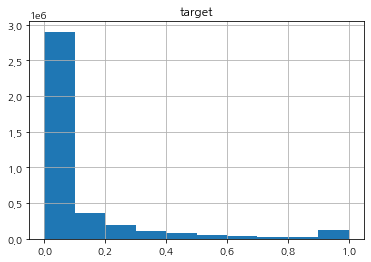

In [13]:
test_df[['target']].hist()

In [62]:
test_df[test_df['ACUM_RCPT_AMT']<1]['ACUM_RCPT_AMT'].min()

0.9992244315876768

In [18]:
train_df_1 = train_df[train_df['target']==1]

In [19]:
train_df_0 = train_df[train_df['target']==0]

<AxesSubplot:>

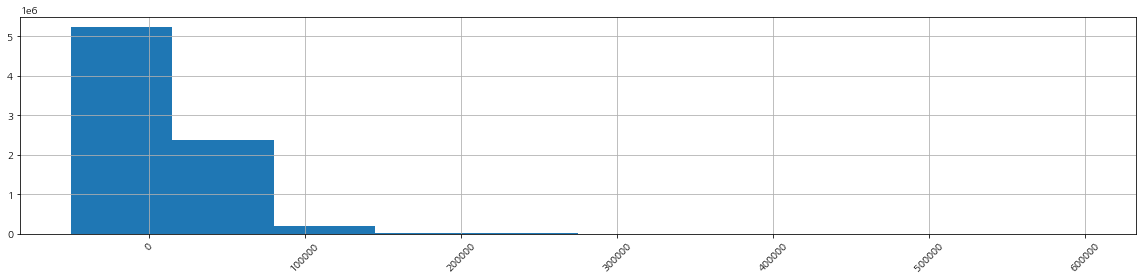

In [14]:
train_df['ACUM_RCPT_AMT'].hist(xrot=45, figsize=(20,4))

<AxesSubplot:>

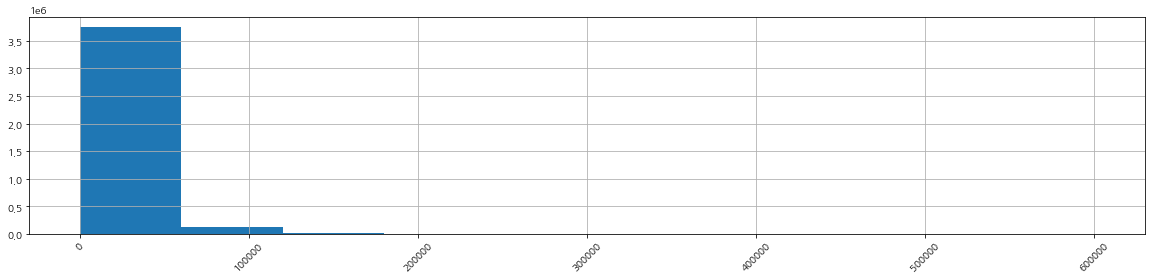

In [15]:
test_df['ACUM_RCPT_AMT'].hist(xrot=45, figsize=(20,4))

In [22]:
train_df_0['ACUM_RCPT_AMT'].min()

1

In [23]:
train_df_1['ACUM_RCPT_AMT'].min()

-49900

In [44]:
train_df[train_df['ACUM_RCPT_AMT']<1]

,TRD_NO,REQ_DD,CP_CD,CP_NM,GODS_NM,PAYR_SEQ,MPHN_NO,COMMC_CLF,AC_PAY_AMT,NPAY_YN,...,AVG_AMT_6M,MAX_LMT_3M_RT,NPAY_CNT_24M,NPAY_CNT_12MNTS,NPAY_AMT_60M,target,datetime,day,weekday,month
64,065b3Dl/CJz9voVMuP7286xgvAwuH8+xLpBi79WHApc=,20190701,843Xm3DeYZwlm4Ygw1tWTA==,V1k6M70/S4nSXnafnxh9EA==,D4OhBk0G5Z3OEEJF+rH+Ks5nQol5Ph7LszHeU6kPGoC3T/...,KcMr/R7ACEf/IG24P7+/FA==,hgPhuUcEezCQIJtwqSm9MA==,CKCCLG,34900,N,...,87720.0,0.39253,3,4,0.0,1,2019-07-01,1,0,7
65,UtHHaxNLD9P/iZZwp1rZrBxHggSpMfBGMEow0sb9ny0=,20190701,843Xm3DeYZwlm4Ygw1tWTA==,V1k6M70/S4nSXnafnxh9EA==,RDI3T0AWVMjUqwKVLWbOdhfjgpk6AU0g2BeH0nOfqDU=,KcMr/R7ACEf/IG24P7+/FA==,hgPhuUcEezCQIJtwqSm9MA==,CKCCLG,27777,N,...,87720.0,0.39253,3,4,0.0,1,2019-07-01,1,0,7
66,nonPnn5qsWIyEGWUcbtms0dzc+BUOL+1PFp3ij57rIw=,20190701,843Xm3DeYZwlm4Ygw1tWTA==,V1k6M70/S4nSXnafnxh9EA==,8IUy87g+xh2bLoKA+WhANHf5J30f+mn547iNwvjAdETv1g...,KcMr/R7ACEf/IG24P7+/FA==,hgPhuUcEezCQIJtwqSm9MA==,CKCCLG,25200,N,...,87720.0,0.39253,3,4,0.0,1,2019-07-01,1,0,7
67,LKt4nC2u5SyDEIdFlmzLp/UKu43B/OL6WuVlWUmzTTc=,20190701,IZddns2EYo6nDeF9GnxwUw==,+lsUGhe8rEyYF+l0oP26aNyxEt8NqJeS2H85ei2Q+uk=,JzWWMKq8X4LhfbAuUYqGkv9U+WAYsIpteNCD9v9+0Ns=,4dcn//08pj/NgfkDnpMalA==,A5ApgyW4+gXCp75S2PNqSA==,CKCCLG,5500,N,...,24235.0,0.01833,2,6,0.0,1,2019-07-01,1,0,7
123,VC92tn7isulj9gaZjQB79e0Bw1rAnafUKwndKPOckaQ=,20190701,eXboVNO2k9x8M5uH109szg==,lHeJucVgXIKTnEkx/7vAXTivd5OWhc6MTtfvvLrOO+w=,KLD+Y8Vfv1s/ojcNfUquog==,iLupOQqVC7jNtLs6pbvCGQ==,FKRMmGzmtbBERScJ6Zi2iQ==,CKCCSK,33000,N,...,434508.0,1.00000,3,12,0.0,1,2019-07-01,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7866500,4EzCxGqQ3+oz20Y6Wg0cdZ7sWgz+JxsnmitQ8iCSsrE=,20191031,A+npLtDXXVBTdDdaKjE1JQ==,lHeJucVgXIKTnEkx/7vAXa/RCq8QoJMmm4NJpd9xhu4=,5jF7Wt2EZF+1AMtQV8Ut+z2Id63VxJ8LvuV7zMO0OJ8=,MSeKTwbx4h7z48+mZpateA==,SCXfEVKNyZ1NJBzYb/D75w==,CKCCLG,49900,N,...,0.0,0.00000,0,0,0.0,1,2019-10-31,31,3,10
7866543,cF2g858ZEHD2f/xKl16mIf/7K+aCKNP6KPljJQXb5tQ=,20191031,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,80000,N,...,0.0,0.00000,0,0,0.0,1,2019-10-31,31,3,10
7866544,BQ32HBAizX/3nNrSpAVNNt6rUIqqpSndFEbUnyLUyFY=,20191031,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,20000,N,...,0.0,0.00000,0,0,0.0,1,2019-10-31,31,3,10
7866545,qvT3uaCvKaCezng8TJNxc1aMug8ocZHAqep9j9K6X2E=,20191031,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,40000,N,...,0.0,0.00000,0,0,0.0,1,2019-10-31,31,3,10


In [40]:
test_df[test_df['ACUM_RCPT_AMT']==0]

,TRD_NO,REQ_DD,CP_CD,CP_NM,GODS_NM,PAYR_SEQ,MPHN_NO,COMMC_CLF,AC_PAY_AMT,NPAY_YN,...,AVG_AMT_6M,MAX_LMT_3M_RT,NPAY_CNT_24M,NPAY_CNT_12MNTS,NPAY_AMT_60M,datetime,day,weekday,month,target
44,kMFEH5NLONTwjNpDrFzJGzhZcStFjRzOS6Yh7ZxClM0=,20191101,eXboVNO2k9x8M5uH109szg==,lHeJucVgXIKTnEkx/7vAXTivd5OWhc6MTtfvvLrOO+w=,Xh4qzvrlDDE/rurBFqLeij2Id63VxJ8LvuV7zMO0OJ8=,/qkbFODGcxp4u7g+lEMj3A==,b4TL1cpeIYTpJGWZPbAckw==,CKCCKT,4290,N,...,92125.0,0.550,1,1,0.0,2019-11-01,1,4,11,1.0
45,x7R7QI0E0z6D8odALCf9FMtzdb9VLeDC+cLOwaXVJtI=,20191101,lLBsBmq7SVtJV2eiUy2Ewg==,lHeJucVgXIKTnEkx/7vAXdWItjDj5MO+0ntVUBNjnNU=,IkZEipg298oRP+tDV25MAVI7xSwLj/0fj4VZdx22Ox4=,/qkbFODGcxp4u7g+lEMj3A==,b4TL1cpeIYTpJGWZPbAckw==,CKCCKT,11000,N,...,92125.0,0.550,1,1,0.0,2019-11-01,1,4,11,1.0
125,vO8oz1oF3yB6EtRhl9b3Wrm0xVI2q/rYAbUkcvAEUIw=,20191102,+Q2ZKhQla9UTj7yTvZ1+xQ==,Lpzf73lR2QPnSpto6bAZB6/aSyMtiZybq4WY9S7miGQ=,g6uplBxhiZs44QjooEs7wVcIM6BFeUiR203oVUBENYE=,Y2jRTMOHVnxTIDEV3irwHA==,+Xy0/iwWNmq57XlqpDNHPg==,CKCCSK,11000,N,...,49117.0,0.447,0,0,60500.0,2019-11-02,2,5,11,1.0
137,64I5kOfI/TWVqRzSMpxyNUU8lA40XDJcpqaGWSxCwmc=,20191102,eXboVNO2k9x8M5uH109szg==,lHeJucVgXIKTnEkx/7vAXTivd5OWhc6MTtfvvLrOO+w=,KLD+Y8Vfv1s/ojcNfUquog==,OS4vh8ddzIpSinoanew6xA==,/d3skdMQeHdZp+filIOLpQ==,CKCCKT,33000,N,...,245525.0,1.000,1,1,0.0,2019-11-02,2,5,11,1.0
138,r7z8ODVsJ9Dt7JsKRoYEyeZZPbrvTtO21RuxAKSUL90=,20191102,eXboVNO2k9x8M5uH109szg==,lHeJucVgXIKTnEkx/7vAXTivd5OWhc6MTtfvvLrOO+w=,REOVlnTnOHQ0l6w7D/dTrQ==,OS4vh8ddzIpSinoanew6xA==,/d3skdMQeHdZp+filIOLpQ==,CKCCKT,11000,N,...,245525.0,1.000,1,1,0.0,2019-11-02,2,5,11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910914,K/7g7AYVaUp3k00Sfo0znbR22UCaFmP0xB2zXax7Tks=,20191231,A+npLtDXXVBTdDdaKjE1JQ==,lHeJucVgXIKTnEkx/7vAXa/RCq8QoJMmm4NJpd9xhu4=,5jF7Wt2EZF+1AMtQV8Ut+z2Id63VxJ8LvuV7zMO0OJ8=,RctR5RCq+RygyUcOZESXCQ==,OY6qLu0r7L6AGA7dEzJAmQ==,CKCCKT,49900,N,...,0.0,0.000,0,0,0.0,2019-12-31,31,1,12,1.0
3910915,NgwGDorLf/co5KAAmBINhLjTUwH1oLhB3t+I506JSD4=,20191231,A+npLtDXXVBTdDdaKjE1JQ==,lHeJucVgXIKTnEkx/7vAXa/RCq8QoJMmm4NJpd9xhu4=,5jF7Wt2EZF+1AMtQV8Ut+z2Id63VxJ8LvuV7zMO0OJ8=,RctR5RCq+RygyUcOZESXCQ==,Zot6ie/RhZt6xrgDbQ9M6Q==,CKCCKT,49900,N,...,0.0,0.000,0,0,0.0,2019-12-31,31,1,12,1.0
3910916,bDOlxavdNyFf1TcNhAiPAzzH5vjf1x6o5OHuQFApJpU=,20191231,A+npLtDXXVBTdDdaKjE1JQ==,lHeJucVgXIKTnEkx/7vAXa/RCq8QoJMmm4NJpd9xhu4=,5jF7Wt2EZF+1AMtQV8Ut+z2Id63VxJ8LvuV7zMO0OJ8=,RctR5RCq+RygyUcOZESXCQ==,OY6qLu0r7L6AGA7dEzJAmQ==,CKCCKT,99000,N,...,0.0,0.000,0,0,0.0,2019-12-31,31,1,12,1.0
3910917,PbRGdDc7UzERU1q75LKoMyo+0rU4j8FzcXQiRK+4r5E=,20191231,A+npLtDXXVBTdDdaKjE1JQ==,lHeJucVgXIKTnEkx/7vAXa/RCq8QoJMmm4NJpd9xhu4=,5jF7Wt2EZF+1AMtQV8Ut+z2Id63VxJ8LvuV7zMO0OJ8=,RctR5RCq+RygyUcOZESXCQ==,Zot6ie/RhZt6xrgDbQ9M6Q==,CKCCKT,99000,N,...,0.0,0.000,0,0,0.0,2019-12-31,31,1,12,1.0


In [28]:
test_df[test_df['CP_M_CLF_NM']=="후원/기부"]['REMD_LMT_AMT'].max()

600000.0

In [24]:
test_df['ACUM_RCPT_AMT'].min()

0

<AxesSubplot:>

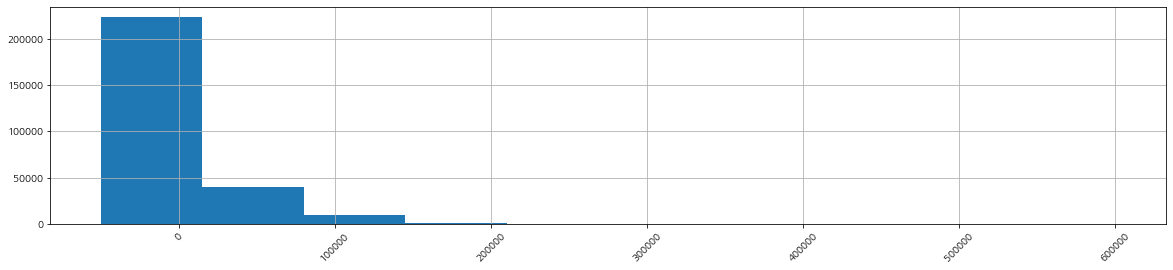

In [11]:
train_df_1['ACUM_RCPT_AMT'].hist(xrot=45, figsize=(20,4))

<AxesSubplot:>

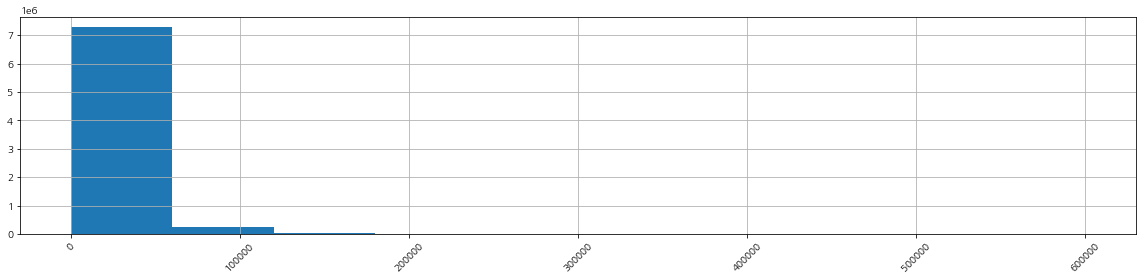

In [12]:
train_df_0['ACUM_RCPT_AMT'].hist(xrot=45, figsize=(20,4))

In [116]:
test_df[test_df['CP_S_CLF_NM']

615662     0.014025
615663     0.016821
735968     0.016923
753631     0.010593
768309     0.009670
             ...   
2260590    0.017234
2722258    0.019538
2744410    0.012673
2763931    0.036590
2790600    0.011596
Name: target, Length: 67, dtype: float64

In [117]:
a = train_df_1['CP_S_CLF_NM'].unique()
b = train_df_0['CP_S_CLF_NM'].unique()
c = test_df['CP_S_CLF_NM'].unique()

In [118]:
d = pd.DataFrame({'A': c})

In [100]:
a = pd.DataFrame({'A': a})

In [104]:
c = pd.DataFrame({'B': b})

In [15]:
train_df_1[['TRD_NO', 'ACUM_RCPT_AMT']].groupby(['ACUM_RCPT_AMT']).count().sort_values(by=['TRD_NO'], ascending=False).head(20)

,TRD_NO
ACUM_RCPT_AMT,
0,195666
49900,12673
11000,6735
50000,5759
99000,5504
55000,3495
9900,2876
19900,2748
33000,2583


In [16]:
train_df_0[['TRD_NO', 'ACUM_RCPT_AMT']].groupby(['ACUM_RCPT_AMT']).count().sort_values(by=['TRD_NO'], ascending=False).head(20)

,TRD_NO
ACUM_RCPT_AMT,
11000,957303
770,464478
9900,459147
5500,433174
19900,299277
1100,238647
4900,233200
49900,219063
110,211955


In [4]:
train_df['PAY_MTHD_CD'].unique()

array([None, 'D', 'R', 'C'], dtype=object)

In [116]:
test_df[test_df['REMD_LMT_AMT']>600000]['target'].tolist()

[0.04654857373137554,
 0.05538438139328879,
 0.02034495348713587,
 0.017630431974653814,
 0.03331840004653767,
 0.20910975869628948,
 0.03250523808757934,
 0.208668748372908,
 0.024851087085139657,
 0.014168784565208429,
 0.011765370534408074,
 0.03923930569554595,
 0.012323597436493139]

In [35]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7866548 entries, 0 to 7866547
Data columns (total 41 columns):
 #   Column            Dtype  
---  ------            -----  
 0   TRD_NO            object 
 1   REQ_DD            int64  
 2   CP_CD             object 
 3   CP_NM             object 
 4   GODS_NM           object 
 5   PAYR_SEQ          object 
 6   MPHN_NO           object 
 7   COMMC_CLF         object 
 8   AC_PAY_AMT        int64  
 9   NPAY_YN           object 
 10  PAY_MTHD_CD       object 
 11  MM_LMT_AMT        float64
 12  REMD_LMT_AMT      float64
 13  ARS_AUTHTI_YN     object 
 14  PAYR_IP           object 
 15  SUB_IP_A          object 
 16  SUB_IP_B          object 
 17  SUB_IP_C          object 
 18  SUB_IP_D          object 
 19  FGPT              object 
 20  AGE               int64  
 21  GNDR              object 
 22  FOREI_YN          object 
 23  SMS_RE_SND_CNT    int64  
 24  AUTHTI_CLF_FLG    object 
 25  ACUM_RCPT_AMT     int64  
 26  PAY_YM        

In [6]:
test_df = pd.read_feather('../../data/.train/.task150/test.feather')

In [30]:
test_df.shape

(3910929, 40)

In [31]:
test_df.head()

,TRD_NO,REQ_DD,CP_CD,CP_NM,GODS_NM,PAYR_SEQ,MPHN_NO,COMMC_CLF,AC_PAY_AMT,NPAY_YN,...,NPAY_AMT_24M,MAX_NPAY_CNT_24M,TRD_CNT_6M,REAL_TRD_CNT_6M,NIGHT_TRD_RT_6M,AVG_AMT_6M,MAX_LMT_3M_RT,NPAY_CNT_24M,NPAY_CNT_12MNTS,NPAY_AMT_60M
0,nv97RPvpsILRkO0BLxDZgs8BHzilzEv8TzSWunbrJsA=,20191101,843Xm3DeYZwlm4Ygw1tWTA==,V1k6M70/S4nSXnafnxh9EA==,Z5l0607IZ5gZA/cP+IOXQHMB/O6KyC5N+QLNmTLrEEc=,8MTAuCXHoh92x6Cmz9IPfA==,Bds0SfbbvXOBj2uafkRSXw==,CKCCSK,25500,N,...,0.0,0,6,6,0.1818,50023.0,0.42447,0,0,0.0
1,81Qha5XTB9l/meAOl1KBPIqYcroUxJ1L4dJM7JpKZSA=,20191101,HF+vkOi8vlEK6e5oOIpa4Q==,lHeJucVgXIKTnEkx/7vAXQuoRdcrPOqMU5Hg/rERCqM=,NefAplKjCgo2SIJ3Cu1UhA==,uZwcpsH+7me5Q9Sf+vmSqg==,bFbrRLMTehU/9q1Yw5kAmQ==,CKCCSK,10900,Y,...,0.0,0,6,0,0.0000,11780.0,0.05393,0,0,0.0
2,Ie/OKGoMzkdBrgpcJUQ2nO4q9Z1ZzzdfPjOaq1yl+m8=,20191101,NRDoE4bt6nBg4HQUfyQBnw==,c0L8iFs6ot6/4z2BW/FjcQ==,Kl4zhJrvoObHaRjhCLiHKLjyJ88HvU41PuQv320+n5I=,wv3zSr/AShgd2vmBwlbxsA==,ULT1b5n7THa2JgU9PnhbMg==,CKCCSK,5500,N,...,0.0,0,6,6,0.1212,64853.0,0.37160,0,0,0.0
3,ni1cHt1R9rxWJxcQO0g87zdrOod7EoJOWz78UES5jhY=,20191101,X87v6k04IapqLN+ZPe6cuQ==,AU5NS0cZS2GOB2xrqlug8mWJT+QZlt3VJzr6RHrt6EA=,ZK7vkU/368myHi7OZUMC6Q==,AOmQAsXpfQCdVUNsrKeZbg==,zGVzAeaEKLp7rS9Eg9Swog==,CKCCLG,31170,N,...,0.0,0,0,0,0.0000,0.0,0.00000,0,0,0.0
4,foBvHXQ3rm8GZMveeXtzf/Yk5Wm9ar0Q73L/zM0Knw4=,20191102,gVrBeEr7BrRMGYPe8Yd+6Q==,lHeJucVgXIKTnEkx/7vAXbEsZF2wRSsYsdozoV8/7eM=,JXtoj4bRhcI+GlJVphB4ami605l/uj21rPatq9QdZjy8iP...,oXP6OZ/aX5On87YIhTBSQg==,RK2Hwe2LExy2blhX5SgpFA==,CKCCLG,110,N,...,10400.0,1,4,4,0.1250,82630.0,0.57740,1,1,0.0


In [36]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910929 entries, 0 to 3910928
Data columns (total 40 columns):
 #   Column            Dtype  
---  ------            -----  
 0   TRD_NO            object 
 1   REQ_DD            int64  
 2   CP_CD             object 
 3   CP_NM             object 
 4   GODS_NM           object 
 5   PAYR_SEQ          object 
 6   MPHN_NO           object 
 7   COMMC_CLF         object 
 8   AC_PAY_AMT        int64  
 9   NPAY_YN           object 
 10  PAY_MTHD_CD       object 
 11  MM_LMT_AMT        float64
 12  REMD_LMT_AMT      float64
 13  ARS_AUTHTI_YN     object 
 14  PAYR_IP           object 
 15  SUB_IP_A          object 
 16  SUB_IP_B          object 
 17  SUB_IP_C          object 
 18  SUB_IP_D          object 
 19  FGPT              object 
 20  AGE               int64  
 21  GNDR              object 
 22  FOREI_YN          object 
 23  SMS_RE_SND_CNT    int64  
 24  AUTHTI_CLF_FLG    object 
 25  ACUM_RCPT_AMT     int64  
 26  PAY_YM        

In [38]:
target_0_num = len(train_df[train_df['target']==0])
target_1_num = len(train_df[train_df['target']==1])
print(f"target == 0 : {target_0_num} ({target_0_num / (target_0_num + target_1_num) * 100} %)")
print(f"target == 1 : {target_1_num} ({target_1_num / (target_0_num + target_1_num) * 100} %)")

target == 0 : 7591835 (96.5078329147677 %)
target == 1 : 274713 (3.492167085232303 %)


In [44]:
train_df.columns

Index(['TRD_NO', 'REQ_DD', 'CP_CD', 'CP_NM', 'GODS_NM', 'PAYR_SEQ', 'MPHN_NO',
       'COMMC_CLF', 'AC_PAY_AMT', 'NPAY_YN', 'PAY_MTHD_CD', 'MM_LMT_AMT',
       'REMD_LMT_AMT', 'ARS_AUTHTI_YN', 'PAYR_IP', 'SUB_IP_A', 'SUB_IP_B',
       'SUB_IP_C', 'SUB_IP_D', 'FGPT', 'AGE', 'GNDR', 'FOREI_YN',
       'SMS_RE_SND_CNT', 'AUTHTI_CLF_FLG', 'ACUM_RCPT_AMT', 'PAY_YM',
       'SVC_CLF_NM', 'CP_M_CLF_NM', 'CP_S_CLF_NM', 'NPAY_AMT_24M',
       'MAX_NPAY_CNT_24M', 'TRD_CNT_6M', 'REAL_TRD_CNT_6M', 'NIGHT_TRD_RT_6M',
       'AVG_AMT_6M', 'MAX_LMT_3M_RT', 'NPAY_CNT_24M', 'NPAY_CNT_12MNTS',
       'NPAY_AMT_60M', 'target'],
      dtype='object')

In [39]:
category_features = [
    "TRD_NO", "CP_CD", "CP_NM", "GODS_NM", "PAYR_SEQ", "MPHN_NO", "COMMC_CLF", "NPAY_YN", 
    "PAY_MTHD_CD", "ARS_AUTHTI_YN", "PAYR_IP", "SUB_IP_A", "SUB_IP_B", "SUB_IP_C", "SUB_IP_D", 
    "FGPT", "GNDR", "FOREI_YN",  "AUTHTI_CLF_FLG", "SVC_CLF_NM", "CP_M_CLF_NM", "CP_S_CLF_NM" 
]

In [53]:
integer_features = [
    "REQ_DD", "AC_PAY_AMT", "AGE", "SMS_RE_SND_CNT", "ACUM_RCPT_AMT", "PAY_YM", "MAX_NPAY_CNT_24M",
    "TRD_CNT_6M", "REAL_TRD_CNT_6M", "NPAY_CNT_24M", "NPAY_CNT_12MNTS"
]

In [50]:
float_features = [
    "MM_LMT_AMT", "REMD_LMT_AMT", "NPAY_AMT_24M", "NIGHT_TRD_RT_6M", "AVG_AMT_6M", "MAX_LMT_3M_RT", 
    "NPAY_AMT_60M"
]

In [40]:
train_df[category_features]

,TRD_NO,CP_CD,CP_NM,GODS_NM,PAYR_SEQ,MPHN_NO,COMMC_CLF,NPAY_YN,PAY_MTHD_CD,ARS_AUTHTI_YN,...,SUB_IP_B,SUB_IP_C,SUB_IP_D,FGPT,GNDR,FOREI_YN,AUTHTI_CLF_FLG,SVC_CLF_NM,CP_M_CLF_NM,CP_S_CLF_NM
0,9iSJiZ+6F/ojR81Swb0CU5oBNWIuJuSsmXsb7aPoWro=,A+npLtDXXVBTdDdaKjE1JQ==,lHeJucVgXIKTnEkx/7vAXa/RCq8QoJMmm4NJpd9xhu4=,5jF7Wt2EZF+1AMtQV8Ut+z2Id63VxJ8LvuV7zMO0OJ8=,pAk55XNz6ES/n8sYT7DXng==,5SfVEIOyxwwfzIU9CHSNwg==,CKCCLG,N,None,N,...,iM+PyOgdFfVlYdg29di2YA==,jhFUR+1ogFimY7EgFm7HHw==,zNmIlCeRY2XH6wwB6wiecw==,ygJH0oaPy6ymDljmog0NHfJ7oDjPcqEufoG9ehvSgCQ9iH...,M,N,S,디지털,게임,게임
1,UStyI9p3TkoNswhaARv+Dzznl7NW4o49XlSEv/jy3/U=,hcyd0jnSmb6YuHJTNdr8Dg==,4oEynZLPEQxD1rYpmkvrYnzPhpVMFYQ6qsWffAWbnsY=,8Og4+xzT5v5Dr+wNcpKsmw==,8MTAuCXHoh92x6Cmz9IPfA==,Bds0SfbbvXOBj2uafkRSXw==,CKCCSK,N,None,N,...,WKRMzxDkXn0avp2lLwtEuw==,gzoVk0VW8RktzYyyN0fImg==,f+NRBNs5LzHpvFhKv1mwcw==,YcqKF5Zdl3ffsyXEeM9mtLGCR4kfBp/IPXlJGQVVuBg9iH...,F,N,S,실물,쇼핑몰(일반),패션
2,PgOykMEKX3so4zIpsNcU+zNt+Nj4VQdwjDB+NlVIJN4=,eXboVNO2k9x8M5uH109szg==,lHeJucVgXIKTnEkx/7vAXTivd5OWhc6MTtfvvLrOO+w=,6Qsgm6RJqycf1R0COrR4kw==,ZWTttap5sIgzmyNlgNV3zQ==,gBFcTvqDAOPW5V4JueXxSQ==,CKCCKT,N,D,N,...,vOPDy9+6ykAutTY1vdkD2w==,hkSNCv9YhHyAYTPDEjceDA==,NxLz08HyXM3sfLvTgfEwkw==,RuGKej7TtOWNyth89EUiBlfd/TFLK9Oq/lEO8RsG6Ww9iH...,M,N,S,디지털,엔터테인먼트,인터넷방송
3,9ngELbCK8cqbPY53oe0eUY+tPvTR/OU7KIMg0pDdh4w=,843Xm3DeYZwlm4Ygw1tWTA==,V1k6M70/S4nSXnafnxh9EA==,wdwtojakimpWekuc2CNjQlzes8jbtaT9xUw5e2GEXJPvDa...,winjRanMlmvBXK5b0+NNrw==,m7CUenl14pnWeYWEV8cWow==,CKCCSK,N,None,N,...,gzoVk0VW8RktzYyyN0fImg==,hkSNCv9YhHyAYTPDEjceDA==,VmXeFyAmIoLuIiLx4gmJww==,NV2ekC4fY1RuLcpz3DHQPfQi6LYEJZHYSTeAaghHySM9iH...,F,N,S,실물,쇼핑몰(종합),소셜커머스
4,sT/zlLzq7AK9QkTSH51L5+LSNY+zkfwrr7PlR4EOMtI=,843Xm3DeYZwlm4Ygw1tWTA==,V1k6M70/S4nSXnafnxh9EA==,yq/HZQss7bpSV2zQ4vkcGerHrkQBGOWSs4j0OumuX8DmOP...,oXP6OZ/aX5On87YIhTBSQg==,RK2Hwe2LExy2blhX5SgpFA==,CKCCLG,N,None,N,...,i0dF1HhgUtdf7y8vGmd9XA==,TvpDuBX19++Jo0D9ShopOQ==,2DagCKiYjIHW7+39U/3egQ==,9++NTgING2RJUEz0B55RovzHt+5eOBmzNUw4ZtrZGN49iH...,F,N,S,실물,쇼핑몰(종합),소셜커머스
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7866543,cF2g858ZEHD2f/xKl16mIf/7K+aCKNP6KPljJQXb5tQ=,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,N,D,N,...,k/0LMUO0sPmgK+wT3m4R0w==,CwOFctdCKz/jLds5gplEDw==,jhFUR+1ogFimY7EgFm7HHw==,m+KGFV3Jl97P7wOZk2uIRtXpuqtxDpEre2wJfB7YzGE9iH...,M,N,S,디지털,게임,게임
7866544,BQ32HBAizX/3nNrSpAVNNt6rUIqqpSndFEbUnyLUyFY=,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,N,D,N,...,k/0LMUO0sPmgK+wT3m4R0w==,CwOFctdCKz/jLds5gplEDw==,jhFUR+1ogFimY7EgFm7HHw==,m+KGFV3Jl97P7wOZk2uIRtXpuqtxDpEre2wJfB7YzGE9iH...,M,N,S,디지털,게임,게임
7866545,qvT3uaCvKaCezng8TJNxc1aMug8ocZHAqep9j9K6X2E=,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,N,D,N,...,k/0LMUO0sPmgK+wT3m4R0w==,CwOFctdCKz/jLds5gplEDw==,jhFUR+1ogFimY7EgFm7HHw==,m+KGFV3Jl97P7wOZk2uIRtXpuqtxDpEre2wJfB7YzGE9iH...,M,N,S,디지털,게임,게임
7866546,Ykft3qZ/7m1gNdS4xGDPyGykVHubQD54Kkni/FwPI68=,aZC4XV9wZ/Wsywo1nTwzFQ==,lHeJucVgXIKTnEkx/7vAXeBzN6Xd/tmW6YvzBP0Lm9TR7K...,nDjDoxEL8SiJE4h01vHwKQUeaEOhhwTOJ3CVURer2ow=,p+tRzKk21+iNaVP4wsULyA==,LOxr0h1gCBoeve3QmMY4wA==,CKCCKT,N,D,N,...,k/0LMUO0sPmgK+wT3m4R0w==,CwOFctdCKz/jLds5gplEDw==,jhFUR+1ogFimY7EgFm7HHw==,m+KGFV3Jl97P7wOZk2uIRtXpuqtxDpEre2wJfB7YzGE9iH...,M,N,S,디지털,게임,게임


In [47]:
high_cardi_features = [
    "TRD_NO", "CP_CD", "CP_NM", "GODS_NM", "PAYR_SEQ", "MPHN_NO", "PAYR_IP", "FGPT",
    "SUB_IP_A", "SUB_IP_B", "SUB_IP_C", "SUB_IP_D"
]

In [44]:
for feature_name in category_features:
    print(f"Unique count for {feature_name} is {len(train_df[feature_name].unique())}")

Unique count for TRD_NO is 7866548
Unique count for CP_CD is 1236
Unique count for CP_NM is 1228
Unique count for GODS_NM is 537526
Unique count for PAYR_SEQ is 2798772
Unique count for MPHN_NO is 2854491
Unique count for COMMC_CLF is 6
Unique count for NPAY_YN is 3
Unique count for PAY_MTHD_CD is 4
Unique count for ARS_AUTHTI_YN is 3
Unique count for PAYR_IP is 2539837
Unique count for SUB_IP_A is 199
Unique count for SUB_IP_B is 256
Unique count for SUB_IP_C is 256
Unique count for SUB_IP_D is 256
Unique count for FGPT is 864510
Unique count for GNDR is 2
Unique count for FOREI_YN is 2
Unique count for AUTHTI_CLF_FLG is 4
Unique count for SVC_CLF_NM is 2
Unique count for CP_M_CLF_NM is 10
Unique count for CP_S_CLF_NM is 50


In [61]:
train_df[["REQ_DD", 'PAY_YM', ]].head()

,REQ_DD,PAY_YM
0,20190701,201907
1,20190701,201907
2,20190702,201907
3,20190701,201907
4,20190702,201907


<AxesSubplot:>

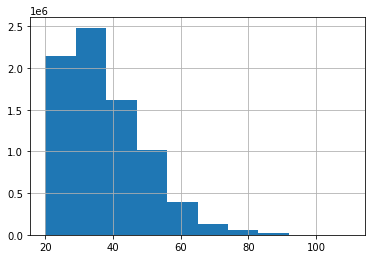

In [70]:
train_df['AGE'].hist()

<AxesSubplot:>

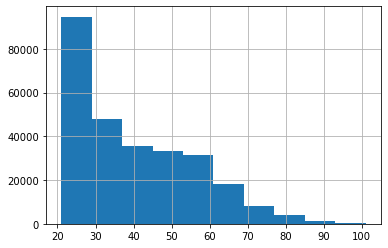

In [71]:
train_df[train_df['target']==1]['AGE'].hist()

In [65]:
# null count for each column
train_df.isnull().sum(axis=0)

TRD_NO                    0
REQ_DD                    0
CP_CD                     0
CP_NM                     0
GODS_NM                  21
PAYR_SEQ                  0
MPHN_NO                   0
COMMC_CLF                 0
AC_PAY_AMT                0
NPAY_YN               10335
PAY_MTHD_CD         5229313
MM_LMT_AMT          5231802
REMD_LMT_AMT          10335
ARS_AUTHTI_YN         10728
PAYR_IP                   0
SUB_IP_A                  0
SUB_IP_B                  0
SUB_IP_C                  0
SUB_IP_D                  0
FGPT                      0
AGE                       0
GNDR                      0
FOREI_YN                  0
SMS_RE_SND_CNT            0
AUTHTI_CLF_FLG            0
ACUM_RCPT_AMT             0
PAY_YM                    0
SVC_CLF_NM                0
CP_M_CLF_NM           69294
CP_S_CLF_NM           69294
NPAY_AMT_24M              0
MAX_NPAY_CNT_24M          0
TRD_CNT_6M                0
REAL_TRD_CNT_6M           0
NIGHT_TRD_RT_6M           0
AVG_AMT_6M          

In [7]:
# null count for each column
test_df.isnull().sum(axis=0)

TRD_NO                    0
REQ_DD                    0
CP_CD                     0
CP_NM                     0
GODS_NM                   4
PAYR_SEQ                  0
MPHN_NO                   0
COMMC_CLF                 0
AC_PAY_AMT                0
NPAY_YN               11712
PAY_MTHD_CD         2601171
MM_LMT_AMT          2603907
REMD_LMT_AMT          11712
ARS_AUTHTI_YN         11747
PAYR_IP                   0
SUB_IP_A                  0
SUB_IP_B                  0
SUB_IP_C                  0
SUB_IP_D                  0
FGPT                      0
AGE                       0
GNDR                      0
FOREI_YN                  0
SMS_RE_SND_CNT            0
AUTHTI_CLF_FLG            0
ACUM_RCPT_AMT             0
PAY_YM                    0
SVC_CLF_NM                0
CP_M_CLF_NM           24258
CP_S_CLF_NM           24258
NPAY_AMT_24M              0
MAX_NPAY_CNT_24M          0
TRD_CNT_6M                0
REAL_TRD_CNT_6M           0
NIGHT_TRD_RT_6M           0
AVG_AMT_6M          

In [79]:
train_df['SVC_CLF_NM'].unique()

array(['디지털', '실물'], dtype=object)

In [77]:
train_df['CP_S_CLF_NM'].unique()

array(['게임', '패션', '인터넷방송', '소셜커머스', '웹하드', '음악', None, '만화/웹툰',
       '교통카드 충전', '폰부가서비스/SMS', '온라인상품권/이용권', 'SNS쇼핑몰', '복권/로또 정보', '호스팅',
       '기프티콘', '기타 교육 관련', '증명서발급', '종합쇼핑몰', '사진/이미지', '인터넷소설', '분양',
       '스포츠토토', '미납금', '연극/영화/공연 티켓 예매', '생활', '온라인교육', '기타', '미팅/채팅',
       '운세정보', 'e-Book', '예약서비스', '포털', '오픈마켓', '아이템', '쿠폰', '택배/물류/이사',
       '행정', '금융/주식/미디어', '사무용품/사무기기', '자선단체', '솔루션개발', '국제전화', 'VPN서비스',
       '스마트홈', '보험', '아이템거래', '문자/팩스', '도서', '전자제품', '게시물등록서비스'],
      dtype=object)

In [ ]:
train_df[['CP_S_CLF_NM', '']]

In [80]:
train_df['CP_S_CLF_NM'].unique()

array(['게임', '패션', '인터넷방송', '소셜커머스', '웹하드', '음악', None, '만화/웹툰',
       '교통카드 충전', '폰부가서비스/SMS', '온라인상품권/이용권', 'SNS쇼핑몰', '복권/로또 정보', '호스팅',
       '기프티콘', '기타 교육 관련', '증명서발급', '종합쇼핑몰', '사진/이미지', '인터넷소설', '분양',
       '스포츠토토', '미납금', '연극/영화/공연 티켓 예매', '생활', '온라인교육', '기타', '미팅/채팅',
       '운세정보', 'e-Book', '예약서비스', '포털', '오픈마켓', '아이템', '쿠폰', '택배/물류/이사',
       '행정', '금융/주식/미디어', '사무용품/사무기기', '자선단체', '솔루션개발', '국제전화', 'VPN서비스',
       '스마트홈', '보험', '아이템거래', '문자/팩스', '도서', '전자제품', '게시물등록서비스'],
      dtype=object)

<AxesSubplot:>

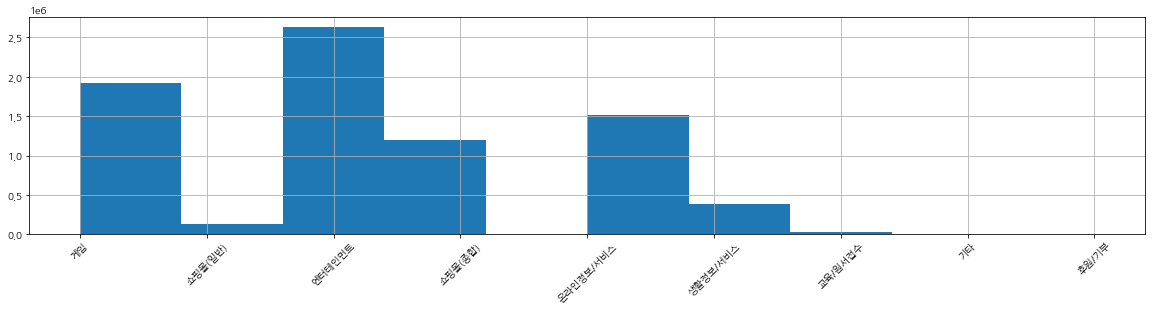

In [32]:
train_df['CP_M_CLF_NM'].hist(xrot=45, figsize=(20,4))

<AxesSubplot:>

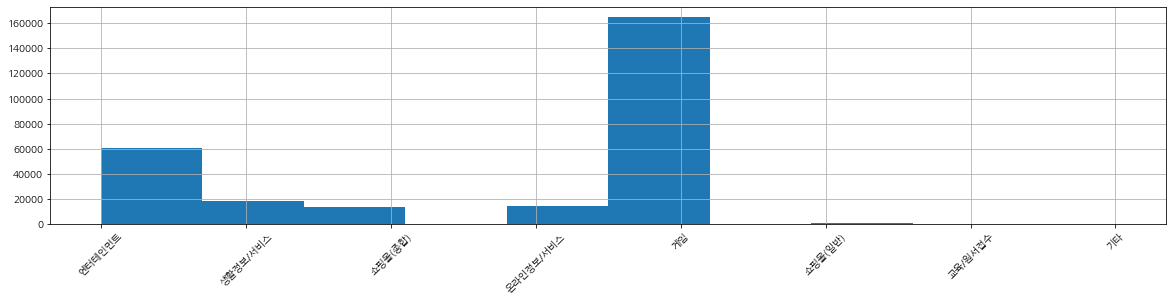

In [31]:
train_df[train_df['target']==1]['CP_M_CLF_NM'].hist(xrot=45, figsize=(20,4))

<AxesSubplot:>

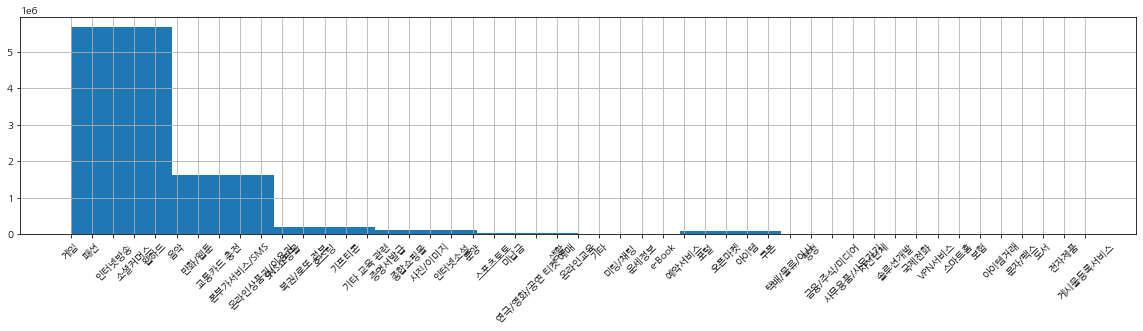

In [16]:
train_df['CP_S_CLF_NM'].hist(xrot=45, figsize=(20,4))

<AxesSubplot:>

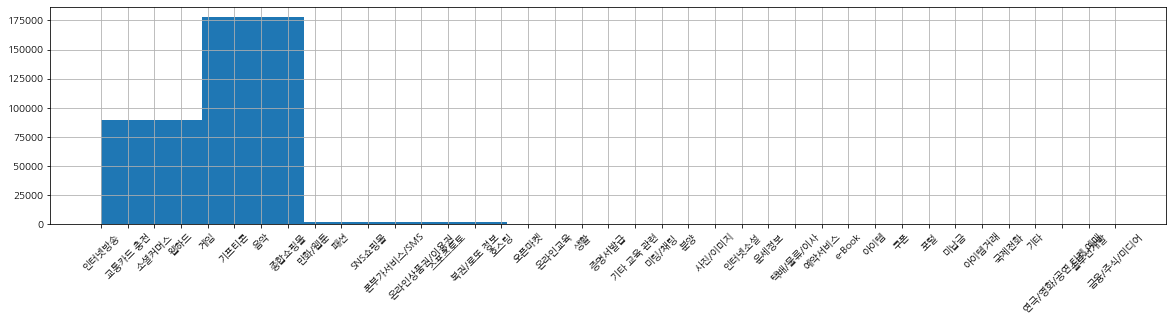

In [17]:
train_df[train_df['target']==1]['CP_S_CLF_NM'].hist(xrot=45, figsize=(20,4))

In [16]:
train_id = pd.read_feather('../../data/.train/.task150/train.feather')[['MPHN_NO', 'target']]
test_id = pd.read_feather('../../data/.train/.task150/test.feather')[['MPHN_NO']]

In [17]:
test_id['test']=1

In [19]:
merged = train_id.merge(test_id, on=['MPHN_NO'], how='left')

In [20]:
merged

,MPHN_NO,target,test
0,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
1,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
2,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
3,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
4,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
...,...,...,...
38192008,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
38192009,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
38192010,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
38192011,LOxr0h1gCBoeve3QmMY4wA==,1,1.0


In [21]:
merged[merged['test']==1]

,MPHN_NO,target,test
0,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
1,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
2,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
3,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
4,5SfVEIOyxwwfzIU9CHSNwg==,0,1.0
...,...,...,...
38192008,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
38192009,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
38192010,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
38192011,LOxr0h1gCBoeve3QmMY4wA==,1,1.0
